In [1]:
import os
import gc
import numpy as np
import tensorflow as tf
from Bio import SeqIO
from utils import preprocessing as pre
from sklearn.model_selection import train_test_split
import models
import pydot
import matplotlib.pyplot as plt
import importlib

In [2]:
gc.collect()
path = '../Data_Sets/PDB/FASTA'
file_name_m = 'mask_3.fasta'
file_name_t = 'mask_torsion.fasta'
dict_ = {'id':[] ,'mask':[],'seq':[], 'mask_bin':[], 'seq_bin':[], 'loss_weight':[], 'seq_int':[], 'coord':[], 'angle':[]}
count = 0
seq_length = 1024
d = {'H':1/0.372, 'B':1/0.2105, 'C':1/0.4173}
for i, rec in enumerate(SeqIO.parse(os.path.join(path,file_name_m),'fasta')):
    
    #if i >50000:
    #    break
    if len(rec.seq)>seq_length:
        continue
        
    #print(rec.id)
    dict_['id'].append(rec.id)
    dict_['seq'].append(rec.seq)
    dict_['seq_int'].append(pre.to_int(rec.seq, max_length=seq_length))
    
    
    
    dict_['mask'].append(rec.description.split('|lcl|')[:len(rec.seq)])
    dict_['mask_bin'].append(pre.to_binary_mask(pre.mask_padding(rec.description.split('|lcl|')[-1], length=seq_length)))
    dict_['loss_weight'].append(pre.loss_weight(rec.description.split('|lcl|')[-1][:len(rec.seq)], d,seq_length))

    
for k, rec in enumerate(SeqIO.parse(os.path.join(path,file_name_t),'fasta')):
        
    #if k >50000:
    #    break
    if len(rec.seq)>seq_length:
        continue
    #print(rec.id)


    f = np.array([ j.split(',')[1:] for j in rec.description.split('|lcl|')[-1].split(';')][1:], dtype=np.float32)
    f = ((360+f)%360)/180 * np.pi - np.pi
    dict_['angle'].append(pre.zero_padding(f,length=seq_length))

        

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(np.array(dict_['seq_int'], dtype = np.int8 ), np.array(dict_['angle'], dtype = np.float32), test_size=0.1, random_state=42)
id_train, id_test, seq_train, seq_test = train_test_split(dict_['id'], dict_['seq'], test_size=0.1, random_state=42)
W_train, W_test, M_train, M_test = train_test_split(dict_['loss_weight'], dict_['mask_bin'], test_size=0.1, random_state=42)

In [4]:
Y_test[0,:10,:]

array([[-3.1415927 , -0.06806827],
       [ 0.8237953 , -2.1170843 ],
       [ 1.9041545 ,  2.820452  ],
       [ 1.839577  ,  2.6040318 ],
       [ 2.1642082 ,  2.5342185 ],
       [ 2.0420353 ,  2.490585  ],
       [ 1.727876  , -0.32812166],
       [ 1.907645  ,  2.9024823 ],
       [ 2.2916172 ,  2.3998277 ],
       [ 2.0036376 ,  2.6755893 ]], dtype=float32)

In [20]:
gc.collect()

8012

In [4]:
p1 = {'max_seq_len': seq_length,
     'num_classes': 3,
     'emb_size': 20,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[4, 4, 4, 4, 4] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.2, 0.2, 0.2, 0.2, 0.2],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.01, 0.01, 0.01, 0.01, 0.01],
     'use_max_pool': False,
     'learning_rate': 1e-4,
    'output_activation': 'softmax'}
p2 = {'max_seq_len': seq_length,
     'num_classes': 32,
     'emb_size': 10,
     'num_filter': [32, 64, 128, 256, 512],
     'kernel_size':[4, 4, 4, 4, 4] ,
     'sampling_stride': [2, 2, 2, 2],
     'pool_size': [2, 2, 2, 2, 2, 2],
     'rate': [0.2, 0.2, 0.2, 0.2, 0.2],
     'l1': [0.0, 0.0, 0.0, 0.0, 0.0],
     'l2': [0.01, 0.01, 0.01, 0.01, 0.01],
     'use_max_pool': False,
     'learning_rate': 1e-4,
    'output_activation': 'softmax',
     'features':32}


def casp_loss(y_pred, y_true):
    return 0

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model1 = models.res_u_net(p1)
    model2 = models.res_u_net_tor(p2)


    model1.load_weights('Weights_MaskModel/w_LDataset')

    inp1 = tf.keras.layers.Input(shape=(seq_length))
    out1, x_o = model1(inp1)
    x1 = tf.keras.layers.Conv1D(32, 7, padding='same')(out1)
    x2 = tf.keras.layers.Conv1D(32, 7, padding='same')(x_o)
    inp2 = tf.keras.layers.Add()([x1,x2])
    out2 = model2(inp2)


    model = tf.keras.Model(inputs = inp1, outputs = [out1,out2])
    mse = tf.keras.losses.MeanSquaredError()
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

    add_1 = tf.keras.optimizers.Adam(learning_rate=1e-4,name='Adam_1')

    opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD')
    
    # Callbacks for Adam optimization
    lr_2 = tf.keras.callbacks.ReduceLROnPlateau(monitor='model_1_loss', factor=0.2, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, min_lr=0.0000001)

    # compiling and fitting with Adam optimizer
    model.compile(optimizer = add_1, loss = [cce, mse], sample_weight_mode="temporal")
    his = []
    li1 = []
    model.load_weights('Weights_MaskModel/w_tor_mod')
    for u in range(10):
        his.append(model.fit(X_train, [M_train, Y_train], batch_size=128, epochs= 100, callbacks= [lr_2], validation_split=0.1, sample_weight = [ np.array(W_train),np.array(W_train)]))
        model.save_weights('Weights_MaskModel/w_tor_mod')
        #li1.append(model.evaluate(x = X_test, y = [M_test,Y_test], batch_size=64, verbose=0))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

KeyboardInterrupt: 

In [5]:
model.save_weights('Weights_MaskModel/w_tor_mod')

In [6]:
with strategy.scope():
    model.load_weights('Weights_MaskModel/w_tor_mod')

IndexError: list index out of range

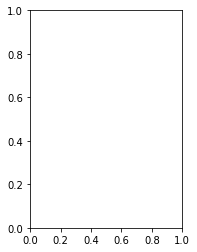

In [9]:
ax1 = plt.subplot(1,2,1)
ax1.plot(his[1].history['loss'])
ax1.plot(his[1].history['val_loss'])
ax2 = plt.subplot(1,2,2)
ax2.plot(his[0].history['val_model_1_loss'])
ax2.set_ylim([0,1])
plt.show()
#ax2.plot(his.history['val_accuracy'])

In [6]:

M_pred, T_pred = model.predict(X_test)


In [24]:
print(Y_test[1,0:60,:])

[[-3.1415927  -2.0996308 ]
 [ 1.0437071  -1.1065388 ]
 [ 1.7191494  -1.1135199 ]
 [ 1.3788102   1.3561213 ]
 [ 1.3264506   3.0543263 ]
 [ 0.64577174 -2.3108158 ]
 [ 1.8133972   0.38571787]
 [ 1.0698869  -1.0855949 ]
 [ 1.3194692  -2.7192228 ]
 [ 1.923353    2.637193  ]
 [ 1.88321     2.9007375 ]
 [-1.9949112  -2.9722955 ]
 [ 0.35953808 -2.4993117 ]
 [ 1.8099067  -0.26179934]
 [ 1.1431906  -2.9932396 ]
 [-2.2567105   0.47822   ]
 [ 1.3491395   1.8692477 ]
 [ 0.35255647 -1.1431906 ]
 [-1.7592918  -2.347468  ]
 [ 0.6126108  -1.0419617 ]
 [ 1.5603244  -0.49741888]
 [ 1.5882494  -0.6614797 ]
 [ 1.2164943  -0.912807  ]
 [ 1.8291047   2.59705   ]
 [ 1.7976892   2.628466  ]
 [ 1.3840458   2.820452  ]
 [-1.9652408  -2.5673795 ]
 [ 0.35430193 -0.38048148]
 [ 1.9303343  -0.71383953]
 [ 0.827286    0.20071292]
 [ 1.9826944  -0.69638634]
 [ 1.5795233  -0.5131266 ]
 [ 0.93375134 -1.9966567 ]
 [ 1.8936822  -3.1415927 ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 

In [14]:
print(T_pred[2,:20,:])

[[-1.5694499  -0.07142629]
 [ 1.1019993  -0.4641437 ]
 [ 1.1536447  -0.4636875 ]
 [ 1.1582164  -0.71167773]
 [ 1.3528682  -0.24029587]
 [ 1.3331226   0.3723785 ]
 [ 1.214086   -0.04831442]
 [ 1.1909322  -0.00558217]
 [-0.05876413  0.20209552]
 [ 1.18658     0.03710468]
 [ 1.3041048  -0.30202124]
 [ 1.976822    2.2719412 ]
 [ 1.9849423   2.3608065 ]
 [ 1.9852419   2.3740468 ]
 [ 1.9965765   2.3704994 ]
 [ 1.9982369   2.3911493 ]
 [ 1.9992958   2.3874564 ]
 [ 1.9918451   2.359342  ]
 [ 1.9727976   2.3354316 ]
 [ 1.9440486   2.2809985 ]]


In [15]:
import time
from utils import layers
importlib.reload(layers)
batch_size = 2
id_ = id_test[]
with tf.device('/cpu:0'):
    coord = layers.CoordinalizationCell(batch_size)
    layer = tf.keras.layers.RNN(coord, return_sequences=True)

    st_1 = tf.constant([[1,-2,0.88] for _ in range(batch_size)])
    st_2 = tf.constant([[1,-1.45,0] for _ in range(batch_size)])
    st_3 = tf.constant([[1.0,0.0,0.0] for _ in range(batch_size)])


    start = time.process_time()
    o = layer(T_pred[:batch_size,:100,:], initial_state=[st_1,st_2,st_3])
    print(time.process_time()-start)

0.7790894330028095


In [22]:
len(seq_test[1])

34

### print(T_pred[0,:10,:])

In [16]:
print(o[0,:10,:])

tf.Tensor(
[[ 0.91375023 -1.011316   -0.3587764   1.619928   -0.84655803  0.10140276
   0.19238216 -1.3405133   0.02241895  0.91896635 -1.7761297   0.04365367]
 [ 0.49048138 -1.9463615   0.91900396  1.1211524  -2.024556    1.4422748
   0.14487088 -1.399015    0.757228   -0.16383687 -1.5725883   1.6585152 ]
 [ 0.7682673  -1.8373079   1.9136522   0.6345812  -2.4289954   1.2810291
   0.12671101 -1.408424    2.3914182   0.10063181 -1.0573208   3.651332  ]
 [ 1.2715977  -1.2192838   2.8839977   1.2443488  -0.16738832  2.4104252
   0.30731273 -1.7387726   3.4726949   1.3525702  -2.5546887   3.8208256 ]
 [ 1.4929587  -3.7336206   4.677298    0.5084049  -3.3086042   5.1999474
   2.4815788  -2.9993603   4.349376    1.2220814  -3.242465    3.7687316 ]
 [ 1.0912082  -2.0897303   4.708447    0.75905204 -2.9402437   5.513897
   1.57618    -2.3648612   3.5167463   1.550177   -0.9717548   3.9018998 ]
 [ 1.4048853  -2.0657468   2.8602426   0.61925244 -1.6098353   3.6879904
   2.4123998  -2.85092     3

In [64]:
d ={'A': 'Ala',
    'C': 'Cys',
    'D': 'Asp',
    'E': 'Glu',
    'F': 'Phe',
    'G': 'Gly',
    'H': 'His',
    'I': 'Ile',
    'K': 'Lys',
    'L': 'Leu',
    'M': 'Met',
    'N': 'Asn',
    'P': 'Pro',
    'Q': 'Gln',
    'R': 'Arg',
    'S': 'Ser',
    'T': 'Thr',
    'V': 'Val',
    'W': 'Trp',
    'Y': 'Tyr',
    'X': 'UNK'}

# Write PDB

#C_C, C_O, C_N, C_Ca
f = open(str(id_test[0])+'.pdb', 'w')

header_str = """PFRMAT TS\nTARGET T0999\nAUTHOR 1234-5678-9000\nREMARK Predictor remarks\nMETHOD Description of methods used\nMETHOD Description of methods used\nMODEL  1 \nPARENT 1abc 1def_A\n"""

f.write(header_str)

for i in range(len(seq_test[0])):
    idx_N  = 4*i
    idx_Ca = 1+4*i
    idx_C  = 2+4*i
    idx_O  = 3+4*i
    
    res = d[seq_test[0][i]]
    
    x_N = o[0,i-1,6].numpy() if i > 0 else 1.0
    y_N = o[0,i-1,7].numpy() if i > 0 else -1.45
    z_N = o[0,i-1,8].numpy() if i > 0 else 0.0
    
    x_Ca = o[0,i-1,9].numpy() if i > 0 else 1.0
    y_Ca = o[0,i-1,10].numpy() if i > 0 else 0.0
    z_Ca = o[0,i-1,11].numpy() if i > 0 else 0.0
    
    x_C = o[0,i,0].numpy()
    y_C = o[0,i,1].numpy()
    z_C = o[0,i,2].numpy()
    
    x_O = o[0,i,3].numpy()
    y_O = o[0,i,4].numpy()
    z_O = o[0,i,5].numpy()
    
    f.write('ATOM%7d  N%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_N,  res, i, x_N, y_N, z_N))
    f.write('ATOM%7d  Ca%5s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00 \n' % (idx_Ca, res, i, x_Ca, y_Ca, z_Ca))
    f.write('ATOM%7d  C%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_C,  res, i, x_C, y_C, z_C))
    f.write('ATOM%7d  O%6s A%4d% 12.3f% 8.3f% 8.3f  1.00  0.00  \n'  % (idx_O,  res, i, x_O, y_O, z_O))
    
f.close()